# Identify negative comments with BERT

**Project Description**
An online store launched a new service - users can edit and complete product descriptions themselves, similar to wiki communities. Therefore, the store needs a tool to look for toxic comments and send them for moderation.

The **task** - based on a dataset tagged with the toxicity of the edits, train a model to classify the comments into positive and negative. Traditionally, the value of the F1 quality metric should be at least 0.75.

## Loading data

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import transformers 
import time
import matplotlib.pyplot as plt

from tqdm import notebook
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from pymystem3 import Mystem
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from nltk import word_tokenize
from PIL import Image
import nltk

In [2]:

df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
display(df.sample(5))
df.info()

,Unnamed: 0,text,toxic
154372,154529,"""Yep, not as easy to do though with the lesser...",0
61408,61475,"Ok, he's been removed from the search engine b...",0
87435,87516,The finding of FACT that he is an Italian lawy...,0
8418,8430,Text edits\nI made a start on editing the text...,0
149249,149405,what do I do if someone keeps lying about me t...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
df = df.dropna()
df= df.reset_index(drop=True)

Let's see what words are most common in toxic and non-toxic tweets. To do this, let's define a few features:

In [5]:
def remove_chars(text, chars): 
    """
    unpunctuate
    """
    return "".join([ch for ch in text if ch not in chars])

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Очистка сделана верно!</font>

In [6]:
def text_cleanup(text):
    """
    stop word removal
    """
    stopset = set(stop_words)
    cleanup = " ".join(filter(lambda word: word not in stopset, text.split()))
    return cleanup

In [7]:
# define special character sets for deletion
spec_chars = string.punctuation + '\n\xa0' 
stop_words = stopwords.words('english')
stop_words.extend(['u', 'im', 'dont' ])

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/ktchka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def make_fdist(n):
    if n in [0, 1]:
        corpus = df.loc[df['toxic'] == n, 'text'].values
        text = ' '.join(corpus)
        text = text.lower()
        text = remove_chars(text, spec_chars)
        text = remove_chars(text, string.digits)
        text_cleaned = text_cleanup(text)
        tokens = word_tokenize(text_cleaned)
        text_cleaned = nltk.Text(tokens)

        if n == 0:
            color = 'darkgreen'
        else:
            color = 'crimson'
        
        fdist = FreqDist(text_cleaned)
        fdist.plot(15, cumulative=False, color=color)
    else:
        print('Put 1 or 0')

Let's take a look at common words for non-toxic tweets:

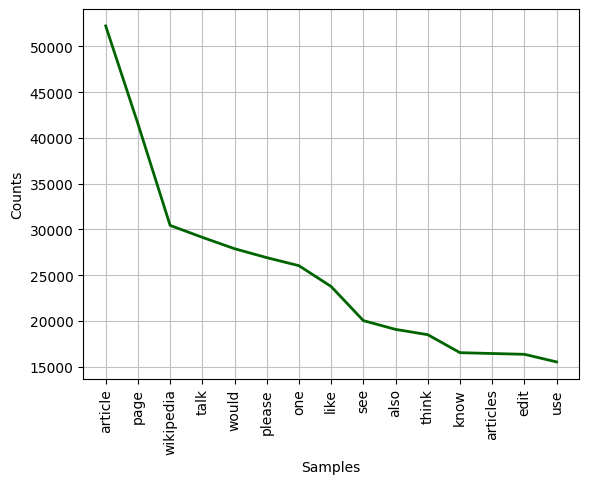

In [13]:
make_fdist(0)


And now for the toxic ones:


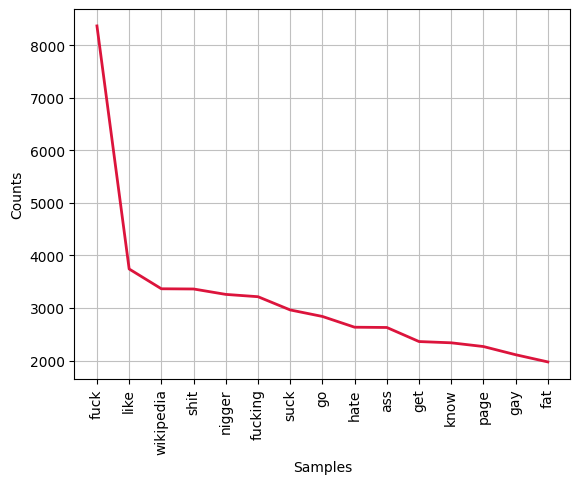

In [14]:
make_fdist(1)

There's not much these sets of words have in common, but there is something - and that's the word "wikipedia".

## Data preparation

Since the dataframe is quite large for bert, we'll take 3000 random rows so that training won't be too long. Let's look at the balance of classes:

0    0.898388
1    0.101612
Name: toxic, dtype: float64


<Axes: >

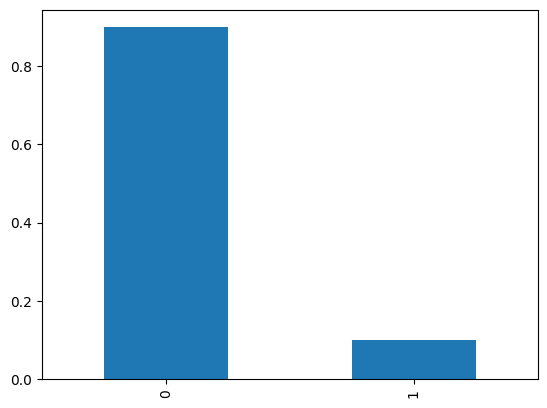

In [15]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

In [16]:
df = df.sample(3000).reset_index(drop=True)
df.shape

(3000, 3)

Let's look at the balance of classes in the resulting sample:

0    0.899333
1    0.100667
Name: toxic, dtype: float64


<Axes: >

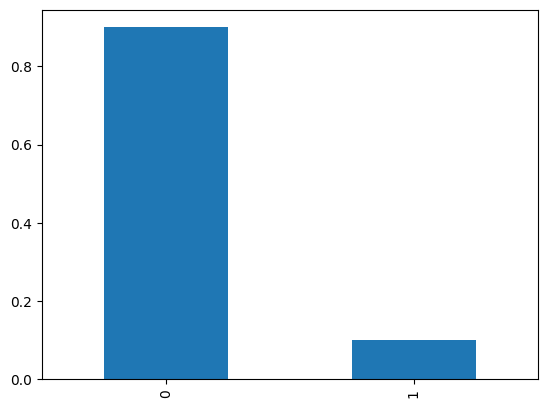

In [17]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 


## BERT

### Text preparation

In [18]:
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

In [19]:
df['tokenized'] = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (907 > 512). Running this sequence through the model will result in indexing errors


We see the message:
`Token indices sequence length is longer than the specified maximum sequence length for this model (1010 > 512). Running this sequence through the model will result in indexing errors`

Therefore, we will only use vectors with length up to 512 to avoid errors.

In [20]:
MAX_LEN = 512
tokenized_proper = []                   
target = []                             

for i in range(df.shape[0]):
    if len(df['tokenized'][i]) <= MAX_LEN:
        tokenized_proper.append(df['tokenized'][i])
        target.append(df['toxic'][i])

In [21]:
tokenized_proper = pd.Series(tokenized_proper)
target = pd.Series(target)

We apply the padding method to equalize the lengths of all vectors, and also define an attention_mask to show the model that zeros do not carry meaningful information:

In [22]:
padded = np.array([i + [0]*(MAX_LEN - len(i)) for i in tokenized_proper])
attention_mask = np.where(padded != 0, 1, 0) 

Initialize the model:

In [23]:
bert_model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')


Convert tokenized texts into embeddings:

In [24]:
%%time

batch_size = 300
embeddings = []

total_batches = (padded.shape[0] // batch_size) + 1

for i in tqdm(range(total_batches)):
    try:
        batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)])

        with torch.no_grad():
            batch_embeddings = bert_model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:, 0, :].numpy())

    except Exception as e:
        print(f"An error occurred: {e}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████████████████████████████████████| 10/10 [58:32<00:00, 351.27s/it]

CPU times: user 30min 11s, sys: 25min 38s, total: 55min 49s
Wall time: 58min 32s


In [25]:
features = np.concatenate(embeddings)

print(features.shape)
print(target.shape)

(2920, 768)
(2920,)


### Training

We divide the dataset into training and test samples:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                   stratify=target)
print(X_train.shape)
print(X_test.shape)

(2336, 768)
(584, 768)


In [36]:
params_dict = {
    'LogisticRegression': {},
    'DecisionTree': {'max_depth': range(1, 7),
                     'min_samples_split': range(2, 7),
                     'min_samples_leaf': range(2, 7)},
    'RandomForest': {'n_estimators': range(1, 7),
                     'max_depth': range(1, 7),
                     'min_samples_split': range(2, 7),
                     'min_samples_leaf': range(2, 7)},
    'CatBoost': {}
}

results_dict = {}


In [49]:
def best_f1_and_params(model_name, n_iter=100):
    if model_name == 'LogisticRegression':
        model = LogisticRegression(random_state=42, solver='liblinear')
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'RandomForest':
        model = RandomForestClassifier(random_state=42)
    elif model_name == 'CatBoost':
        model = CatBoostClassifier(verbose=False, iterations=300, learning_rate=0.001, random_state=42)
        
    params = params_dict[model_name]
    random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=n_iter, 
                                       scoring='f1', random_state=42)
    random_search.fit(X_train, y_train)
    
    f1 = random_search.best_score_
    best_params = random_search.best_params_
    best_estimator = random_search.best_estimator_
    
    print(f'Best F1 score for {model_name}: {round(f1, 3)}')
    
    results_dict[model_name] = {'F1': f1, 'best_params': best_params, 'best_estimator': best_estimator}


### Logistic Regression

In [50]:
best_f1_and_params('LogisticRegression')

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best F1 score for LogisticRegression: 0.937


### Decision Tree

In [51]:
best_f1_and_params('DecisionTree')

Best F1 score for DecisionTree: 0.912


### Random Forest

In [52]:
best_f1_and_params('RandomForest')

Best F1 score for RandomForest: 0.929


### CatBoost

In [53]:
best_f1_and_params('CatBoost')

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best F1 score for CatBoost: 0.938


Let's combine the results into a single df

In [54]:
results_df = pd.DataFrame(results_dict).T


# Conclusion

In [55]:
results_df['F1']

LogisticRegression    0.936511
DecisionTree          0.911853
RandomForest          0.929331
CatBoost              0.938194
Name: F1, dtype: object

CatBoost and LogisticRegression show better results, let's check the models on a test sample

In [56]:
model_lr = results_dict['LogisticRegression']['best_estimator']
pred_test = model_lr.predict(X_test)
print(f'Best F1 score for LogisticRegression :', round(f1_score(y_test, pred_test), 3))

Best F1 score for LogisticRegression : 0.942


In [57]:
model_cb = results_dict['CatBoost']['best_estimator']
pred_test = model_cb.predict(X_test)
print(f'Best F1 score for CatBoost :', round(f1_score(y_test, pred_test), 3))


Best F1 score for CatBoost : 0.939


The task was accomplished using the pre-trained BERT(toxic-bert) model. The value obtained on the test sample using LogisticRegression is higher than that of CatBoost - 0.957, the value exceeds the value set by the customer in 0.75.

The following steps were performed during the work:

* Downloaded and read the data;

* Performed frequency analysis of the text - built a graph for the most frequent words in the texts;

* Transformed the texts using pre-trained BERT(toxic-bert) model;

* Trained different models;

* Built a table with the metric values for each model;

* Selected the best model.
